# Machine Learning - Lab 4
Partners: SJ Franklin, Nick Largey

# <center> A Study of Factors related to Cardiovascular risk in Adults </center>


The objective of this notebook is to show some of the essential steps of a workflow for building predictive models. The notebook provides a few examples of each step and it is only a very thin slice of what a complete analysis would consist of.

The workflow includes:
1. **Problem Definition**:  A clear definition of the problem enables us to identify the appropriate data to gather and technique(s) to use in order to solve the problem. For many problems this many require background reading, discussion with domain experts, and layered problem specification.
2. **Data Gathering**: We have to know which data to use, where to gather them, and how to make them useful to solve our problem. In many cases, data from multiple sources can provide deeper insights.
3. **Data Cleaning and Wrangling**: Raw data are generally incomplete, inconsistent, and contain many errors. Thus, we need to prepare the data for further processing. Data wrangling is the process of cleaning, structuring, and enriching raw data into another format with the intent of making it more appropriate and valuable for a variety of downstream purposes, such as analytics.
4. **Exploratory Data Analysis**: Exploratory data analysis (EDA) is an approach of performing initial investigations on our data. EDA normally has descriptive nature and uses graphical statistics to discover patterns, to identify anomalies, to test hypothesis, and to check assumptions regarding our data.

5. **Data Modelling**:  Data modelling involves selecting and optiming the machine learning models that generate the best predictive performance based on the data we have.
6. **Prediction**: Once we have developed the best predictive model, we can deploy it to make predictions.


References :
1. https://github.com/richasethi3/CVD_Prediction
2. https://www.kaggle.com/ar2017/titanic-end-to-end-ml-workflow-top-7/notebook
3. https://github.com/bruceMacLeod/COS475-575/blob/main/Assignment/HypertensionV1.ipynb

# Problem Definition

Cardiovascular disease (CVD) is a general term for conditions affecting the heart or blood vessels. It's usually associated with a build-up of fatty deposits inside the arteries (atherosclerosis) and an increased risk of blood clots. It can also be associated with damage to arteries in organs such as the brain, heart, kidneys and eyes.

CVD is one of the main causes of death and disability in the USA, but it can often largely be prevented by leading a healthy lifestyle.

The exact cause of CVD isn't clear, but there are lots of things that can increase your risk of getting it. These are called "risk factors". The more risk factors you have, the greater your chances of developing CVD.

1.  **High blood pressure** (hypertension) is one of the most important risk factors for CVD. If your blood pressure is too high, it can damage your blood vessels.

2.   **Smoking** Smoking and other tobacco use is also a significant risk factor for CVD. The harmful substances in tobacco can damage and narrow your blood vessels.

3.   **High cholesterol** Cholesterol is a fatty substance found in the blood. If you have high cholesterol, it can cause your blood vessels to narrow and increase your risk of developing a blood clot.


4.   **Diabetes** Diabetes is a lifelong condition that causes your blood sugar level to become too high. High blood sugar levels can damage the blood vessels, making them more likely to become narrowed.

5.    **Inactivity** If you don't exercise regularly, it's more likely that you'll have high blood pressure, high cholesterol levels and be overweight. All of these are risk factors for CVD.

6.    **Being overweight or obese** Being overweight or obese increases your risk of developing diabetes and high blood pressure, both of which are risk factors for CVD.

We apply the tools of machine learning to predict the factors that are associated with cardiovascular disease in adults.



# Data Gathering and Import


In [2]:
#Before moving to the next section, we need to import all packages required to do the analysis by calling the following:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import tarfile
import urllib
import logging

from functools import reduce

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix



### Gathering and Importing Data

We need some functions to help automate the large number of files

In [3]:
def download_data(data_dir, file_list):

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    for (year, data_file) in file_list:
        sub_dir = os.path.join(data_dir, year)
        if not os.path.exists(sub_dir):
            os.makedirs(sub_dir)
        url = 'http://wwwn.cdc.gov/Nchs/Nhanes/{0}/{1}.XPT'.format(year, data_file)
        file_name = os.path.join(sub_dir, data_file + '.XPT')
        if not os.path.exists(file_name):
            logging.info('Downloading: {}'.format(url))
            urllib.request.urlretrieve(url, file_name)
        else:
            logging.info('File exists: {}'.format(file_name))

def read_data_from_row(offset,ncols,col_list):
    df = pd.DataFrame()
    for i in range(ncols):
        filename = LOCAL_DATA_PATH + file_list[offset + i][0] + "/" + file_list[offset + i][1] + ".XPT"
        one_year_df = pd.read_sas(filename)
        df = pd.concat([df,one_year_df], axis=0)
    df = df.loc[:, col_list]
    return df

In [4]:
file_list = [
        ('2015-2016', 'DEMO_I'),    ('2017-2018', 'DEMO_J'),  ('2013-2014', 'DEMO_H'),
        ('2015-2016', 'BPX_I'),     ('2017-2018', 'BPX_J'),   ('2013-2014', 'BPX_H'),
        ('2015-2016', 'BMX_I'),     ('2017-2018', 'BMX_J') ,  ('2013-2014', 'BMX_H'),
        ('2015-2016', 'TCHOL_I'),   ('2017-2018', 'TCHOL_J'), ('2013-2014', 'TCHOL_H'),
        ('2015-2016', 'DIQ_I'),     ('2017-2018', 'DIQ_J'),   ('2013-2014', 'DIQ_H'),
        ('2015-2016', 'SMQ_I'),     ('2017-2018', 'SMQ_J'),   ('2013-2014', 'SMQ_H'),
        ('2015-2016', 'MCQ_I'),     ('2017-2018', 'MCQ_J'),   ('2013-2014', 'MCQ_H'),
        ('2015-2016', 'HDL_I'),     ('2017-2018', 'HDL_J'),   ('2013-2014', 'HDL_H'),
        ('2015-2016', 'TRIGLY_I'),  ('2017-2018', 'TRIGLY_J'),('2013-2014', 'TRIGLY_H'),
        ('2015-2016', 'KIQ_U_I'),   ('2017-2018', 'KIQ_U_J'), ('2013-2014', 'KIQ_U_H')
    ]

demo_cols = ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'INDFMIN2']
bpx_cols = ['SEQN', 'BPXPULS','BPXSY1', 'BPXDI1']
bmx_cols = ['SEQN', 'BMXBMI', 'BMXWAIST']
tchol_cols = ['SEQN', 'LBXTC']
diab_cols = ['SEQN', 'DIQ010']
smoking_cols = ['SEQN', 'SMQ020']
heart_cols = ['SEQN', 'MCQ160B', 'MCQ160C', 'MCQ160D', 'MCQ160E', 'MCQ160F', 'MCQ300A']
hdl_cols = ['SEQN', 'LBDHDD']
trigly_cols = ['SEQN', 'LBXTR', 'LBDLDL']
kidney_cols = ['SEQN', 'KIQ022']


In [5]:
LOCAL_DATA_PATH = os.path.join("datasets", "nhanes") + "/"

download_data(LOCAL_DATA_PATH, file_list)

In [6]:
demo_df = read_data_from_row(0,3,demo_cols)
bpx_df = read_data_from_row(3,3,bpx_cols)
bmx_df = read_data_from_row(6,3,bmx_cols)
tchol_df = read_data_from_row(9,3,tchol_cols)
diab_df = read_data_from_row(12,3,diab_cols)
smoking_df = read_data_from_row(15,3,smoking_cols)
heart_df = read_data_from_row(18,3,heart_cols)
hdl_df = read_data_from_row(21,3,hdl_cols)
trigly_df = read_data_from_row(24,3,trigly_cols)
kidney_df = read_data_from_row(27,3,kidney_cols)

### Merge the datatables into a single table

In [7]:
pdList = [demo_df, bpx_df, bmx_df, hdl_df, trigly_df, tchol_df, diab_df,
          kidney_df, heart_df, smoking_df]
cvd_df = reduce(lambda x,y: pd.merge(x,y, on='SEQN', how='outer'), pdList)

In [8]:
#rename the columns to make the headers to something more meaningful
cvd_df.rename(columns={'SEQN': 'seqn', 'RIAGENDR': 'gender', 'RIDAGEYR':'age',
                   'RIDRETH1':'ethnicity', 'INDFMIN2':'income', 'BPXPULS':'pulse_regular',
                   'BPXSY1':'sysbp', 'BPXDI1':'diabp', 'BMXBMI':'bmi',
                   'BMXWAIST':'waistcircum', 'LBDHDD':'hdl', 'LBXTR':'trigly',
                   'LBDLDL':'ldl', 'LBXTC':'totchol', 'DIQ010':'diabetes',
                   'KIQ022':'kidney_fail', 'MCQ160B':'congestive_fail', 'MCQ160C':'coronary_disease',
                   'MCQ160D':'angina', 'MCQ160E':'heart_attack',
                   'MCQ160F':'stroke', 'MCQ300A':'fam_history', 'SMQ020':'smoking'}, inplace=True)
cvd_df.set_index('seqn', inplace=True)
cvd_df.head()

,gender,age,ethnicity,income,pulse_regular,sysbp,diabp,bmi,waistcircum,hdl,...,totchol,diabetes,kidney_fail,congestive_fail,coronary_disease,angina,heart_attack,stroke,fam_history,smoking
seqn,,,,,,,,,,,,,,,,,,,,,
83732.0,1.0,62.0,3.0,10.0,1.0,128.0,70.0,27.8,101.1,46.0,...,173.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
83733.0,1.0,53.0,3.0,4.0,1.0,146.0,88.0,30.8,107.9,63.0,...,265.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
83734.0,1.0,78.0,3.0,5.0,1.0,138.0,46.0,28.8,116.5,30.0,...,229.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0
83735.0,2.0,56.0,3.0,10.0,1.0,132.0,72.0,42.4,110.1,61.0,...,174.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,9.0,2.0
83736.0,2.0,42.0,4.0,7.0,1.0,100.0,70.0,20.3,80.4,53.0,...,204.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


###  Exploring Data Structure and Features
Before performing data analysis, we often need to know the structure of our data. Therefore, we perform the following:
- Viewing a small part of our datasets
- Viewing data shape
- Describing the features contained in the datasets

In [9]:
cvd_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 29400 entries, 83732.0 to 83731.0
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            29400 non-null  float64
 1   age               29400 non-null  float64
 2   ethnicity         29400 non-null  float64
 3   income            28474 non-null  float64
 4   pulse_regular     27106 non-null  float64
 5   sysbp             20619 non-null  float64
 6   diabp             20619 non-null  float64
 7   bmi               25816 non-null  float64
 8   waistcircum       24575 non-null  float64
 9   hdl               21618 non-null  float64
 10  trigly            8703 non-null   float64
 11  ldl               8612 non-null   float64
 12  totchol           21618 non-null  float64
 13  diabetes          28241 non-null  float64
 14  kidney_fail       17057 non-null  float64
 15  congestive_fail   17057 non-null  float64
 16  coronary_disease  17057 non-nu

In [10]:
# Only want to analysis on adults

cvd_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 29400 entries, 83732.0 to 83731.0
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            29400 non-null  float64
 1   age               29400 non-null  float64
 2   ethnicity         29400 non-null  float64
 3   income            28474 non-null  float64
 4   pulse_regular     27106 non-null  float64
 5   sysbp             20619 non-null  float64
 6   diabp             20619 non-null  float64
 7   bmi               25816 non-null  float64
 8   waistcircum       24575 non-null  float64
 9   hdl               21618 non-null  float64
 10  trigly            8703 non-null   float64
 11  ldl               8612 non-null   float64
 12  totchol           21618 non-null  float64
 13  diabetes          28241 non-null  float64
 14  kidney_fail       17057 non-null  float64
 15  congestive_fail   17057 non-null  float64
 16  coronary_disease  17057 non-nu

In [11]:
#count and find the percentage of null values and concatenat the results
missing = pd.concat([cvd_df.isnull().sum(), 100*cvd_df.isnull().mean()], axis=1)
missing.columns = ['count', 'percentage']
missing.sort_values(by='count', ascending=False)

,count,percentage
ldl,20788,70.707483
trigly,20697,70.397959
fam_history,12343,41.982993
stroke,12343,41.982993
heart_attack,12343,41.982993
angina,12343,41.982993
coronary_disease,12343,41.982993
congestive_fail,12343,41.982993
kidney_fail,12343,41.982993
smoking,11439,38.908163


# Data Cleaning and Wrangling

## Starting with the missing values

In [12]:
cvd_df.shape

(29400, 22)

In [13]:
#filering out the ldl null values from the dataset
cvd_df = cvd_df[cvd_df['ldl'].notna()].reset_index(drop=True)

In [14]:
cvd_df.shape

(8612, 22)

In [15]:
#look at the count and percentage of missing values again
missing = pd.concat([cvd_df.isnull().sum(), 100*cvd_df.isnull().mean()], axis=1)
missing.columns = ['count', 'percentage']
missing.sort_values(by='count', ascending=False)

,count,percentage
kidney_fail,1501,17.429169
fam_history,1501,17.429169
stroke,1501,17.429169
heart_attack,1501,17.429169
angina,1501,17.429169
coronary_disease,1501,17.429169
congestive_fail,1501,17.429169
smoking,1141,13.248955
sysbp,709,8.232699
diabp,709,8.232699


Taking out the missing ldl values has taken care of missing trigly values and the rest of the missing columns as well.

In [16]:
cvd_df = cvd_df[cvd_df['heart_attack'].notna()].reset_index(drop=True)
#look at the count and percentage of missing values again
missing = pd.concat([cvd_df.isnull().sum(), 100*cvd_df.isnull().mean()], axis=1)
missing.columns = ['count', 'percentage']
missing.sort_values(by='count', ascending=False)

,count,percentage
sysbp,595,8.367318
diabp,595,8.367318
waistcircum,331,4.654760
pulse_regular,226,3.178175
income,187,2.629729
bmi,82,1.153143
gender,0,0.000000
kidney_fail,0,0.000000
fam_history,0,0.000000
stroke,0,0.000000


This has resulted in reduction of our dataset by over 75%. Let's impute the rest of the missing sysbp, diabp, bmi and waistcircum columns by the median. Impute pulse_regular by mode, and forward fill the income column.

In [17]:
cvd_df.shape

(7111, 22)

In [18]:
cvd_df[['sysbp', 'diabp', 'bmi', 'waistcircum']] = cvd_df[['sysbp', 'diabp', 'bmi',
                                                           'waistcircum']].fillna(cvd_df[['sysbp', 'diabp',
                                                                                          'bmi', 'waistcircum']].median())

In [19]:
cvd_df['pulse_regular'].fillna(cvd_df['pulse_regular'].mode()[0], inplace=True)

In [20]:
cvd_df['income'].fillna(method='ffill', inplace=True)

In [21]:
cvd_df.dtypes

gender              float64
age                 float64
ethnicity           float64
income              float64
pulse_regular       float64
sysbp               float64
diabp               float64
bmi                 float64
waistcircum         float64
hdl                 float64
trigly              float64
ldl                 float64
totchol             float64
diabetes            float64
kidney_fail         float64
congestive_fail     float64
coronary_disease    float64
angina              float64
heart_attack        float64
stroke              float64
fam_history         float64
smoking             float64
dtype: object

In [22]:
dtype_cols = [col for col in cvd_df.columns if col not in ['bmi', 'waistcircum']]

for col in dtype_cols:
    cvd_df[col] = cvd_df[col].astype('int')
cvd_df.dtypes

gender                int64
age                   int64
ethnicity             int64
income                int64
pulse_regular         int64
sysbp                 int64
diabp                 int64
bmi                 float64
waistcircum         float64
hdl                   int64
trigly                int64
ldl                   int64
totchol               int64
diabetes              int64
kidney_fail           int64
congestive_fail       int64
coronary_disease      int64
angina                int64
heart_attack          int64
stroke                int64
fam_history           int64
smoking               int64
dtype: object

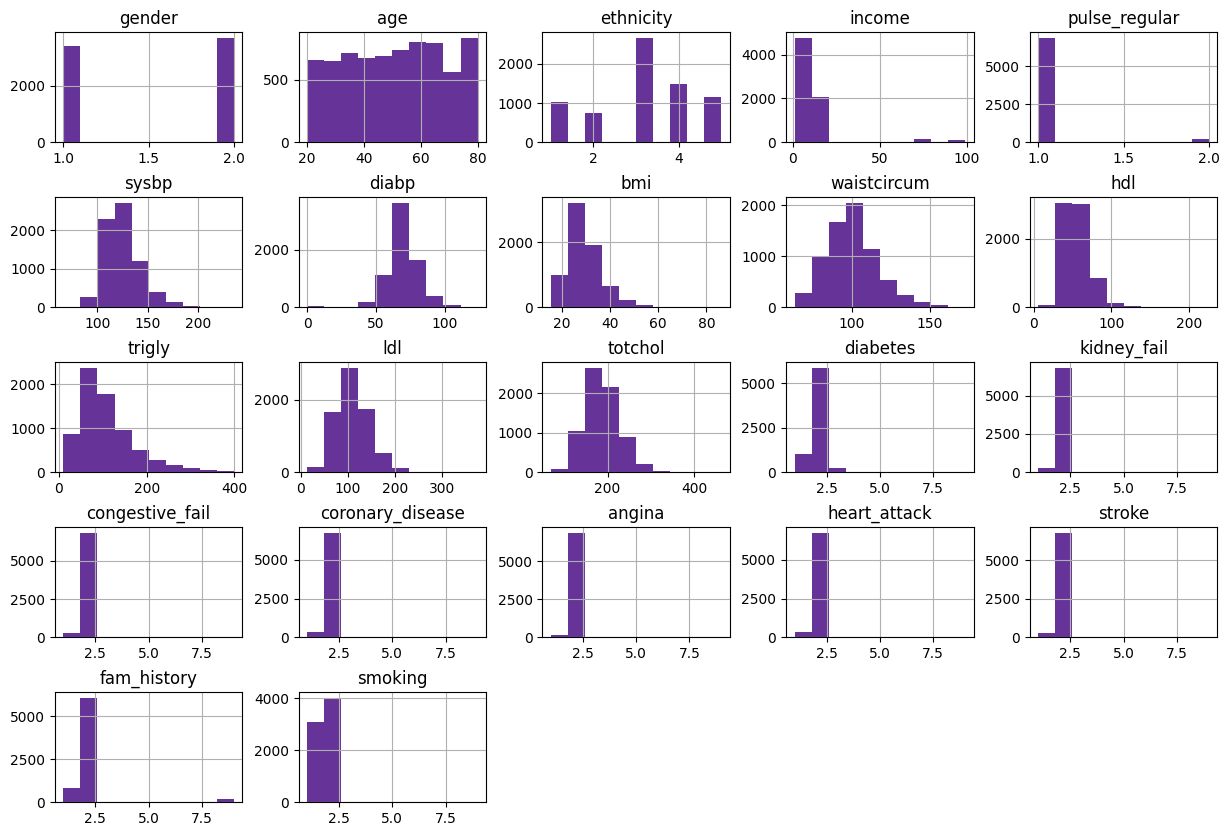

In [23]:
#let's get the histograms to get an idea of their distributions
cvd_df.hist(figsize=(15, 10), color='rebeccapurple')
plt.subplots_adjust(hspace=0.5)
plt.show()

### filter out rows, columns, recode

In [24]:
def hyper(sbp, dbp):
    if ((sbp <= 130) and (dbp <= 80)):
        return 0
    else:
        return 1

In [25]:
#def a function which takes different heart condions as input and returns 1 if either one is true
#this is going to be our target
def CVD(heart_1, heart_2, heart_3, heart_4, heart_5):
    if ((heart_1 == 1) or (heart_2 == 1) or (heart_3 == 1)
       or (heart_4 == 1) or (heart_5 == 1)):
        return 1
    else:
        return 0

In [26]:
def cvd_recode_values(cvd_df):
    #replace the 1(male) from the original dataset to 0 and 2(female) to 1
    cvd_df['gender'].replace({1: 0, 2: 1}, inplace=True)

    # replace 13(under $20,000) by 4($15,000 to $19,999)
    #replace 12(over $20,000), 77(refused) and 99(don't know) by mode($25,000 to $34,999).
    cvd_df['income'].replace({13: 4, 12: 6, 77: 6, 99: 6}, inplace=True)

    #Here 1 means the individual has been told they have diabetes, 2 means no diabetes, 3 means borderline and 9 stands for refused
    #replace 3 by 1 and 9 by 2
    cvd_df['diabetes'].replace({3: 1, 9: 2}, inplace=True)

    #Here 1 means the individual has had kidney failure, 2 means no kidney failure and 9 stands for refused
    #replace 9 by 2
    cvd_df['kidney_fail'].replace({9: 2}, inplace=True)

    # Here 1 means the individual has had congestive heart failure, 2 means no congestive heart failure and 9 stands for refused.
    #replace 9 by 2
    cvd_df['congestive_fail'].replace({9: 2}, inplace=True)

    #Here 1 means the individual has had coronary heart disease, 2 means no congestive coronary heart disease and 9 stands for refused.
    cvd_df['coronary_disease'].replace({9: 2, 7: 2}, inplace=True)

    #Here 1 means the individual has had angina, 2 means no angina and 9 stands for refused.
    cvd_df['angina'].replace({9: 2}, inplace=True)

    # Here 1 means the individual has had heart attack, 2 means no heart attack and 9 stands for refused.
    #replace 9 by 2
    cvd_df['heart_attack'].replace({9: 2}, inplace=True)

    #Here 1 means the individual has had stroke, 2 means no stroke and 9 stands for refused.
    #replace 9 by 2
    cvd_df['stroke'].replace({9: 2}, inplace=True)

    #Here 1 means the individual has family history of heart disease, 2 means no family history of heart disease, 7 means don't know and 9 stands for refused.
    #replace 9 and 7 by 2
    cvd_df['fam_history'].replace({9: 2, 7: 2}, inplace=True)

    #Here 1 means the individual smokes, 2 means no smoking, 7 means don't know and 9 stands for refused.
    #replace 9 and 7 by 2
    cvd_df['smoking'].replace({9: 2, 7: 2}, inplace=True)
    return cvd_df


In [27]:
def cvd_add_attributes(cvd_df):
    if ('congestive_fail' in cvd_df.columns) &  ('coronary_disease' in cvd_df.columns) & \
       ('angina' in cvd_df.columns) & ('heart_attack' in cvd_df.columns) & \
       ('stroke' in cvd_df.columns) :
       cvd_df['CVD_risk'] = cvd_df.apply(lambda x: CVD(x['congestive_fail'], x['coronary_disease'],
                                         x['angina'], x['heart_attack'],
                                         x['stroke']), axis=1)
    if ('sysbp' in cvd_df.columns) & ('diabp' in cvd_df.columns) :
       cvd_df['hypertension_cat'] = cvd_df.apply(lambda x : hyper(x['sysbp'], x['diabp']), axis=1)
    return cvd_df

In [28]:
def cvd_trim_rows(cvd_df):
    # only want to do the analysis on adults
    if ('age' in cvd_df.columns):
        cvd_df = cvd_df[cvd_df.age >=20]
    return cvd_df

In [29]:
def cvd_drop_columns(cvd_df):
        if ('congestive_fail' in cvd_df.columns) &  ('coronary_disease' in cvd_df.columns) & \
           ('angina' in cvd_df.columns) & ('heart_attack' in cvd_df.columns) & \
           ('stroke' in cvd_df.columns) :
            cvd_df = cvd_df.drop(columns=['congestive_fail', 'coronary_disease', 'angina', 'heart_attack', 'stroke'], axis=1)# We do not need the seqn now (only needed for the merge)
        if ('sysbp' in cvd_df.columns) & ('diabp' in cvd_df.columns) :
            cvd_df = cvd_df.drop(columns=['sysbp','diabp'],axis=1)
        return cvd_df


In [30]:
def cvd_add_trim__recode_drop(cvd_df):
    cvd_df = cvd_trim_rows(cvd_df)
    cvd_df = cvd_add_attributes(cvd_df)
    cvd_df = cvd_recode_values(cvd_df)
    cvd_df = cvd_drop_columns(cvd_df)

    return cvd_df

In [31]:
cvd_df.head()

,gender,age,ethnicity,income,pulse_regular,sysbp,diabp,bmi,waistcircum,hdl,...,totchol,diabetes,kidney_fail,congestive_fail,coronary_disease,angina,heart_attack,stroke,fam_history,smoking
0,1,53,3,4,1,146,88,30.8,107.9,63,...,265,2,2,2,2,2,2,2,2,1
1,1,78,3,5,1,138,46,28.8,116.5,30,...,229,1,1,2,2,2,1,2,2,1
2,2,42,4,7,1,100,70,20.3,80.4,53,...,204,2,2,2,2,2,2,2,2,2
3,2,72,1,14,1,116,58,28.6,92.9,78,...,190,2,2,2,2,2,2,2,2,2
4,1,22,4,7,1,110,70,28.0,86.6,48,...,164,2,2,2,2,2,2,2,1,1


In [32]:
cvd_df = cvd_add_trim__recode_drop(cvd_df)
cvd_df.head()

,gender,age,ethnicity,income,pulse_regular,bmi,waistcircum,hdl,trigly,ldl,totchol,diabetes,kidney_fail,fam_history,smoking,CVD_risk,hypertension_cat
0,0,53,3,4,1,30.8,107.9,63,147,173,265,2,2,2,1,0,1
1,0,78,3,5,1,28.8,116.5,30,269,145,229,1,1,2,1,1,1
2,1,42,4,7,1,20.3,80.4,53,47,142,204,2,2,2,2,0,0
3,1,72,1,14,1,28.6,92.9,78,46,103,190,2,2,2,2,0,0
4,0,22,4,7,1,28.0,86.6,48,68,102,164,2,2,1,1,0,0


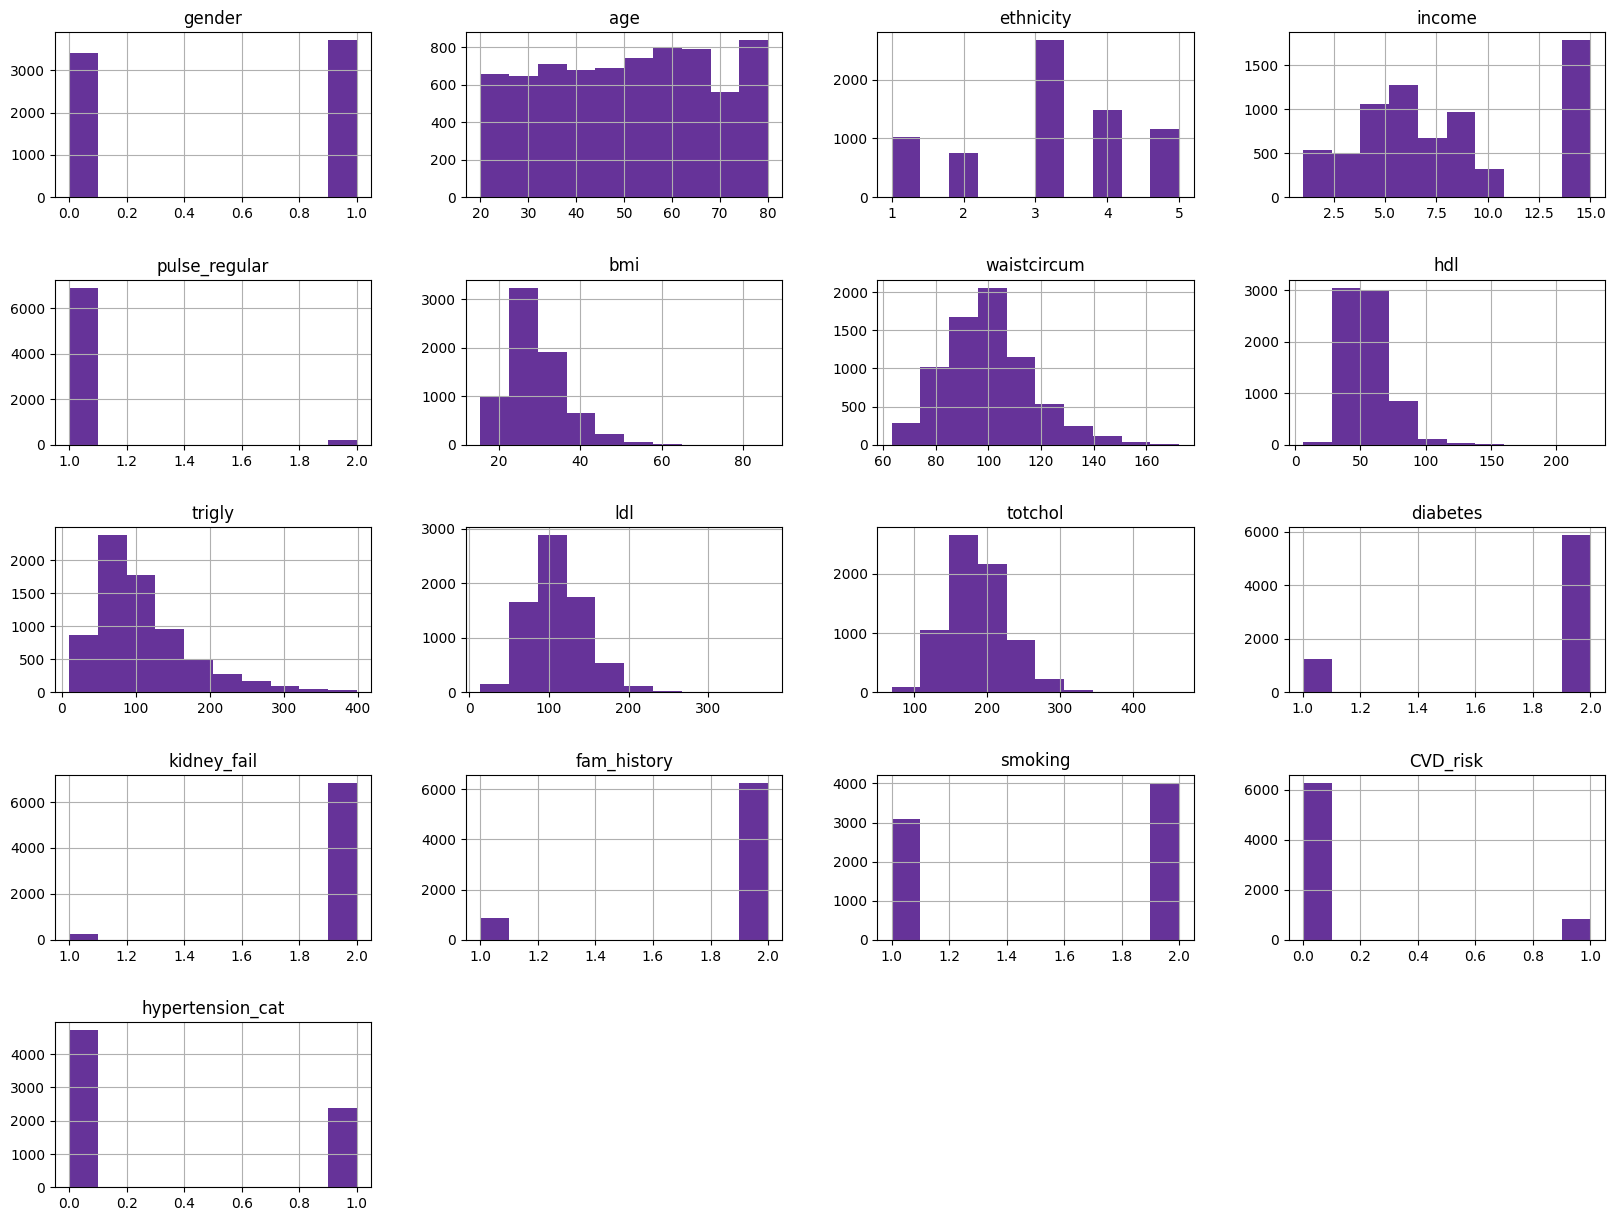

In [33]:
#get the new histograms to get an idea of their distributions
cvd_df.hist(figsize=(20, 15), color='rebeccapurple')
plt.subplots_adjust(hspace=0.5)
plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')
plt.show()

In [34]:
#setting up a datapath for our file
if not os.path.exists(LOCAL_DATA_PATH):
    os.mkdir(datapath)
datapath_cvd_data = os.path.join(LOCAL_DATA_PATH, 'cvd_data_cleaned.csv')
if not os.path.exists(datapath_cvd_data):
    cvd_df.to_csv(datapath_cvd_data, index=False)

### Now split into training and test data sets

In [35]:
y = cvd_df['CVD_risk']
X = cvd_df.drop('CVD_risk',axis=1)

In [36]:
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train,  X_val, y_train, y_val = train_test_split(X_train,y_train,  test_size=0.1, random_state=42)

In [37]:
#confirming the ratios of train, test and validation sets for X
print('Percent heldout for training:', round(100*(len(X_train)/len(cvd_df)),0),'%')
print('Percent heldout for validation', round(100*(len(X_val)/len(cvd_df)),0),'%')
print('Percent heldout for testing:', round(100*(len(X_test)/len(cvd_df)),0),'%')

Percent heldout for training: 72.0 %
Percent heldout for validation 8.0 %
Percent heldout for testing: 20.0 %


In [38]:
#confirming the ratios of train, test and validation sets for y
print('Percent heldout for training:', round(100*(len(y_train)/len(cvd_df)),0),'%')
print('Percent heldout for validation:', round(100*(len(y_val)/len(cvd_df)),0),'%')
print('Percent heldout for testing:', round(100*(len(y_test)/len(cvd_df)),0),'%')

Percent heldout for training: 72.0 %
Percent heldout for validation: 8.0 %
Percent heldout for testing: 20.0 %


# Exploratory Data Analysis

In [39]:
y_train.value_counts(normalize=True)

0    0.882399
1    0.117601
Name: CVD_risk, dtype: float64

In [40]:
y_val.value_counts(normalize=True)

0    0.891037
1    0.108963
Name: CVD_risk, dtype: float64

Our data is highly imbalanced with about 11% individuals with CVD risk. We may have to take this into account while modeling

In [41]:

Xy_train = X_train.copy()
Xy_train['CVD_risk'] = y_train
Xy_grouped = Xy_train.groupby('CVD_risk')[['age',  'bmi', 'waistcircum',
                                   'hdl', 'trigly', 'ldl', 'totchol']].mean().reset_index()
Xy_grouped

,CVD_risk,age,bmi,waistcircum,hdl,trigly,ldl,totchol
0,0,48.492362,29.218353,99.151406,54.943989,107.865176,112.510959,189.029666
1,1,66.132890,30.703654,105.672757,51.747508,117.509967,96.317276,171.563123


In [42]:
#def a function to plot barplots for the mean of grouped features
def barplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.3, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        barlist=ax.bar(x = 'CVD_risk', height = col, data=Xy_grouped)
        barlist[0].set_color('forestgreen')
        barlist[1].set_color('darkred')
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['No', 'Yes'], fontsize=14, color='black')
        ax.set_xlabel('CVD risk',fontsize=14, color='black')
        ax.set_ylabel(col, fontsize=14, color='black')
    nsubplots = nrow * ncol
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [43]:
features = [i for i in Xy_grouped.columns if i not in ['CVD_risk']]

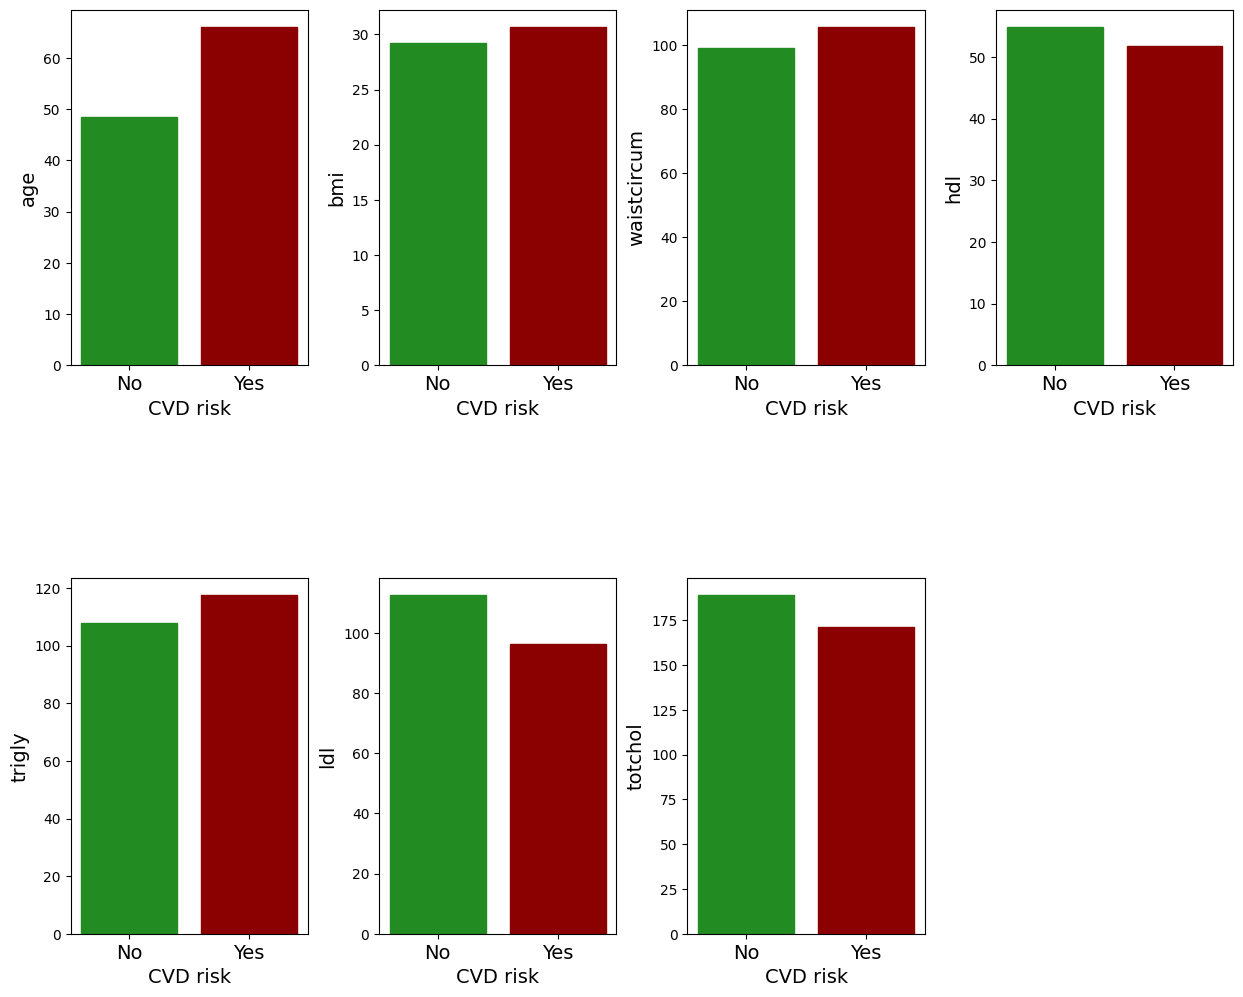

In [44]:
barplots(features, ncol=4, figsize=(15, 12))

In [45]:
Xy_train.columns

Index(['gender', 'age', 'ethnicity', 'income', 'pulse_regular', 'bmi',
       'waistcircum', 'hdl', 'trigly', 'ldl', 'totchol', 'diabetes',
       'kidney_fail', 'fam_history', 'smoking', 'hypertension_cat',
       'CVD_risk'],
      dtype='object')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5]),
 [Text(0, 0.5, 'gender'),
  Text(0, 1.5, 'age'),
  Text(0, 2.5, 'bmi'),
  Text(0, 3.5, 'waistcircum'),
  Text(0, 4.5, 'hdl'),
  Text(0, 5.5, 'ldl'),
  Text(0, 6.5, 'trigly'),
  Text(0, 7.5, 'totchol'),
  Text(0, 8.5, 'diabetes'),
  Text(0, 9.5, 'kidney_fail'),
  Text(0, 10.5, 'fam_history'),
  Text(0, 11.5, 'smoking'),
  Text(0, 12.5, 'CVD_risk')])

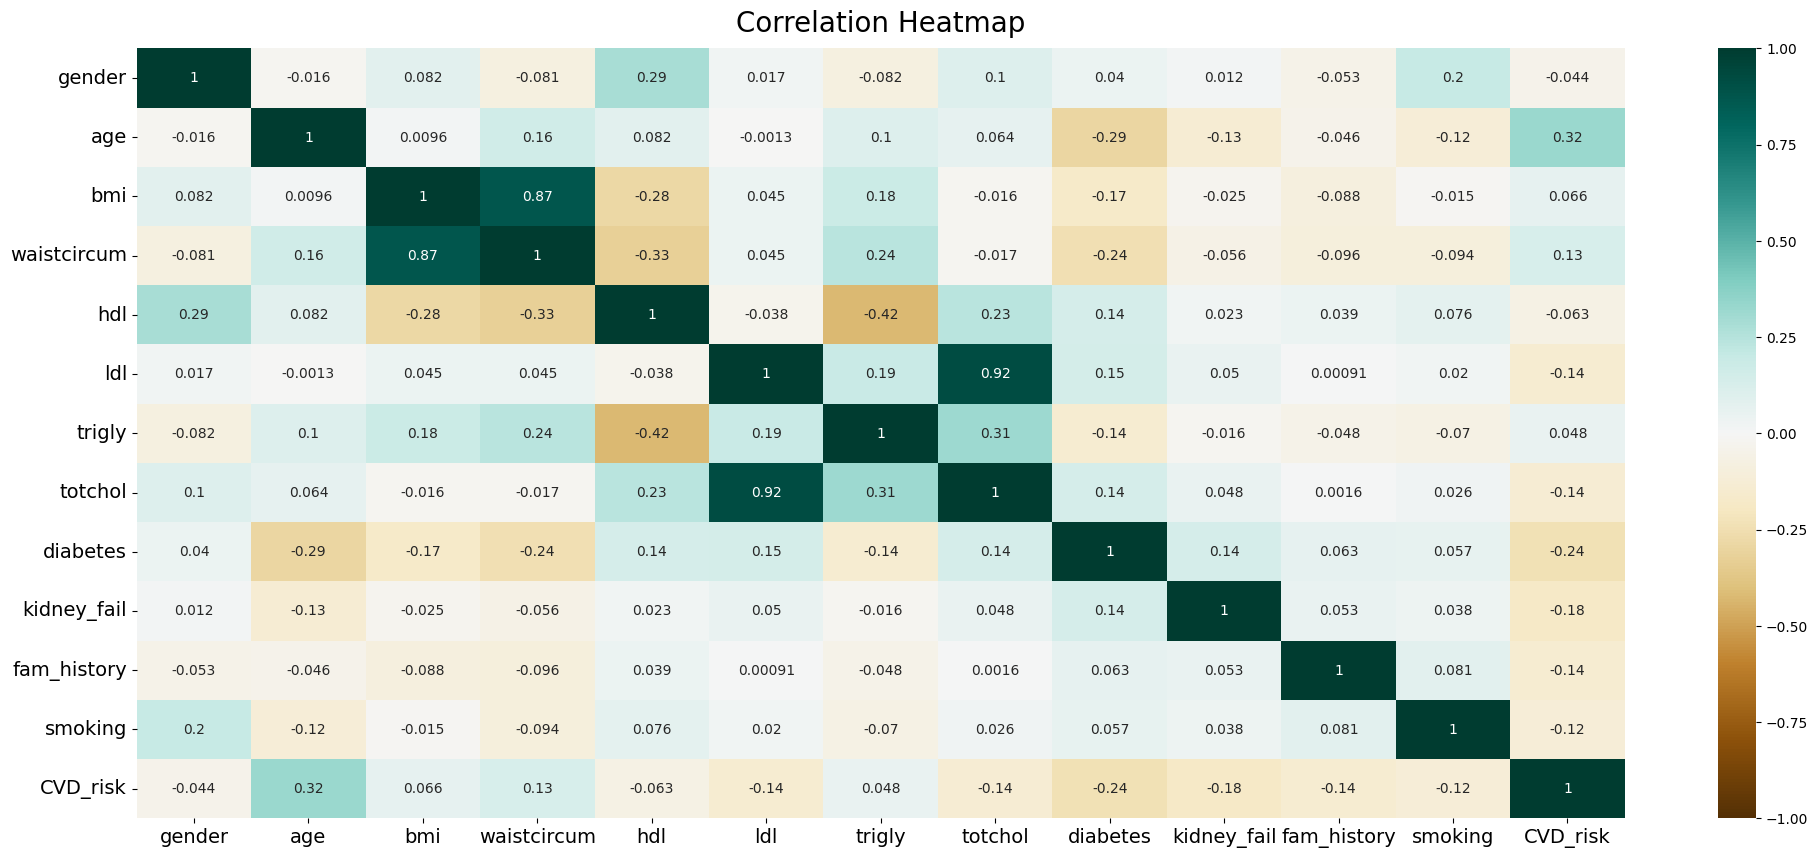

In [46]:
# Adding heatmaps
corr = Xy_train[['gender', 'age',  'bmi', 'waistcircum', 'hdl', 'ldl', 'trigly', 'totchol',
               'diabetes', 'kidney_fail', 'fam_history', 'smoking', 'CVD_risk']].corr()
plt.figure(figsize=(24,10))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, cmap='BrBG', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')

### More graph and EDA needed (todo)

## Setup the pipeline to normalize values

### set missing values of numerical data to the median

In [47]:
X_train.head()

,gender,age,ethnicity,income,pulse_regular,bmi,waistcircum,hdl,trigly,ldl,totchol,diabetes,kidney_fail,fam_history,smoking,hypertension_cat
7100,0,68,4,4,1,19.1,84.5,64,40,57,129,2,2,2,1,0
1189,1,59,3,15,1,24.3,91.6,80,56,80,171,2,2,2,2,0
1441,0,60,1,7,1,33.6,111.2,47,185,130,214,2,2,1,1,1
4148,1,65,4,3,1,25.9,97.8,60,75,43,118,2,1,1,2,0
4898,1,59,5,8,1,26.6,91.1,60,112,108,190,2,2,1,2,1


In [48]:
X_train.columns

Index(['gender', 'age', 'ethnicity', 'income', 'pulse_regular', 'bmi',
       'waistcircum', 'hdl', 'trigly', 'ldl', 'totchol', 'diabetes',
       'kidney_fail', 'fam_history', 'smoking', 'hypertension_cat'],
      dtype='object')

In [49]:
num_attribs = ['age', 'income', 'bmi', 'waistcircum', 'hdl', 'trigly', 'ldl', 'totchol']
cat_attribs = ["gender","ethnicity", "pulse_regular", 'diabetes', 'kidney_fail', 'fam_history', 'smoking', 'hypertension_cat']

#cvd_num = cvd_df.drop(cat_attribs,axis=1)

In [50]:

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
        ])

In [51]:

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
        ])
cvd_prepared = full_pipeline.fit_transform(X_train)

In [52]:
cvd_prepared.shape

(5119, 27)

In [53]:
cvd_prepared[1,0:27]

array([ 0.4808439 ,  1.61807488, -0.70348048, -0.50708712,  1.54368392,
       -0.82500205, -0.84970757, -0.38877784,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        1.        ,  0.        ])

### Create a dataframe from the prepared numpy array so we can view data

In [54]:
cvd_df[cat_attribs].apply(pd.Series.value_counts)

,gender,ethnicity,pulse_regular,diabetes,kidney_fail,fam_history,smoking,hypertension_cat
0,3402.0,NaN,NaN,NaN,NaN,NaN,NaN,4718.0
1,3709.0,1029.0,6910.0,1241.0,269.0,851.0,3089.0,2393.0
2,NaN,759.0,201.0,5870.0,6842.0,6260.0,4022.0,NaN
3,NaN,2673.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1487.0,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,1163.0,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
column_names = num_attribs.copy()
column_names.extend(['Male','Female',
                     'Mexican','Hispanic','White','Black','Other',
                     'Pulse_regular', 'Pulse_irreg',
                     'diabetes','no_diabetes',
                     'kidney_fail', 'no_kidney_fail',
                     'fam_history', 'no_fam_hist',
                     'smoking', 'no_smoking',
                     'hypertension', 'no_hypertension'])
cvd_prepared_df = pd.DataFrame(cvd_prepared, columns=column_names)
cvd_prepared_df.T

,0,1,2,3,4,5,6,7,8,9,...,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118
age,0.994012,0.480844,0.537863,0.822956,0.480844,1.393143,-0.773567,1.564199,0.708919,0.024694,...,0.081713,0.480844,1.450162,-1.628848,0.195750,0.879975,0.309788,0.879975,-1.286736,1.279106
income,-0.925040,1.618075,-0.231463,-1.156232,-0.000271,-0.231463,-1.156232,-1.156232,1.386883,-1.618617,...,-1.156232,1.618075,-0.925040,-0.462656,-0.462656,-0.925040,-0.462656,-0.231463,-1.618617,1.386883
bmi,-1.421737,-0.703480,0.581093,-0.482479,-0.385790,0.705407,-0.316727,-1.104047,0.346279,0.677782,...,-0.703480,-0.965920,-0.523916,-1.546050,-0.302914,0.912596,0.926409,0.180527,1.437476,1.382226
waistcircum,-0.939905,-0.507087,0.687734,-0.129134,-0.537567,0.632870,0.072035,-1.275186,0.011075,1.236376,...,-0.744832,-0.921617,0.132996,-0.086461,-0.714352,0.937671,0.023267,0.797462,1.620426,1.151032
hdl,0.572505,1.543684,-0.459372,0.329710,0.329710,0.572505,-0.884263,0.086916,-0.216578,-0.641468,...,-1.005661,0.936697,-1.127058,-0.398674,1.422287,-0.520071,0.208313,-1.066359,-0.520071,0.936697
trigly,-1.074062,-0.825002,1.183044,-0.529243,0.046708,-0.404713,2.225983,-0.575942,-0.202352,-0.202352,...,0.607093,-0.482545,0.077840,-0.389147,-0.793870,0.965117,-0.140087,-0.326882,-0.560376,-0.762737
ldl,-1.488240,-0.849708,0.538406,-1.876911,-0.072364,0.899315,0.482881,-0.211175,-1.155092,-0.294462,...,2.176379,0.510643,-1.571526,-1.071806,-0.155651,-0.127889,0.399594,-0.655372,1.371274,-0.988519
totchol,-1.410880,-0.388778,0.657660,-1.678573,0.073602,0.901017,0.755003,-0.340106,-1.167522,-0.583464,...,1.704097,0.681995,-1.800252,-1.216194,0.195280,-0.023742,0.389966,-1.094515,0.828010,-0.729478
Male,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
Female,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000


#  Data Modeling

### Stochastic Gradient Descent

In [56]:

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(cvd_prepared, y_train)

SGDClassifier(random_state=42)

In [57]:
some_data = cvd_prepared[5]
some_labels = y_train.iloc[5]
sgd_clf.predict([some_data])

array([0])

In [58]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, cvd_prepared, y_train, cv=3, scoring="accuracy")

array([0.88752197, 0.88393904, 0.85697538])

## Confusion Matrix

### Exercise : Construct a confusion matrix

In [59]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, cvd_prepared, y_train, cv=3)
confusion_matrix(y_train, y_train_pred)

array([[4383,  134],
       [ 500,  102]])

### Exercise : Provide your thoughts on the numbers in the confusion matrix, including an analysis of why things may not be working out so well.

True negatives: 4383
True positives: 102
False negatives: 500
False positives: 134

Earlier when exploring the data we found that only about 11% of people in our dataset are at risk for CVD. This imbalance in our dataset is similar to the MNIST dataset, where if a model were to predict that every person is not at risk of CVD, it would be correct about 90% of the time. This means our true negatives are misleading, and we need to pay more attention to our false negatives and false positives. Since we have more false negatives than false positives, this most likely means the model doesn't have enough information to be able to make the connections it needs to predict CVD risk. This supports what we see in the bar graphs earlier, where there are few "easy" correlations between our various datapoints and CVD risk.

## Precision and Recall

### Exercise : Calculate the Precision, Recall, and F1-score

In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(y_train, y_train_pred))
print(recall_score(y_train, y_train_pred))
print(f1_score(y_train, y_train_pred))

0.4322033898305085
0.16943521594684385
0.24343675417661095


### Provide your thoughts on precision, recall, and F1-score, including an analysis of why things may not be working out so well.

These scores are quite low, and additionally our F1 score shows that we aren't quite near the harmonic mean as we would want to be.
Our recall scores being this low also supports our previous claim that the model isn't accurately able to predict any correlations between CVD risk.

## Precision/Recall Trade-off

### Exercise : Construct a graph of the Precision and Recall values as the threshold changes  

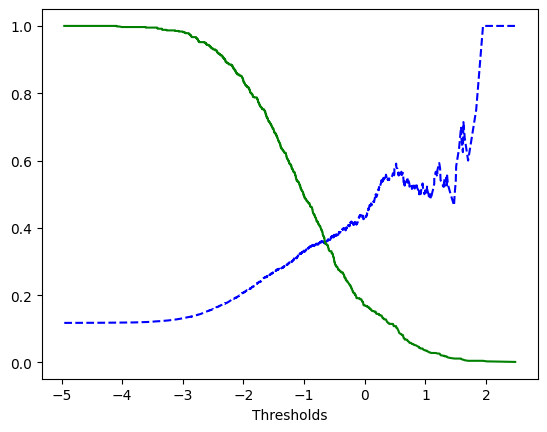

In [64]:
from sklearn.metrics import precision_score

y_scores = cross_val_predict(sgd_clf, cvd_prepared, y_train, cv=3, method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  [...]
  # Label the x-axis
  plt.xlabel('Thresholds')


plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### Exercise : Why does the precision curve look jagged ?

As Sean said: because it goes "wrah-wruh"

Precision and recall are proportional to each other, but the precision curve is especially jagged. We can understand the reason by understanding how the graph plots these lines. Each point represents the change in values over different threshold points. The expected response may be that as we change the threshold to lower our recall, our precision value will always increase, but this is not always the case. Sometimes the precision value goes down as recall goes down. This is what the jagged points represent. This can be seen fairly well between the 1 and 2 values of our blue precision line: there are several points where the line dips, rises, then dips again. The overall trend of precision though is generally increasing.

## The ROC Curve

### Exercise : Construct and ROC curve

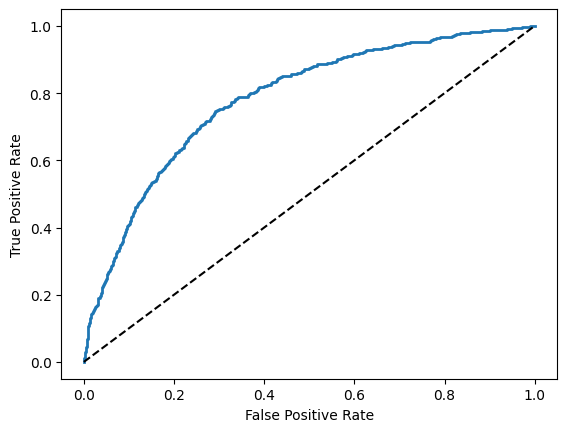

In [62]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')
  [...]
  # Label the x-axis and y-axis
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')


plot_roc_curve(fpr, tpr)
plt.show()

### Graduate Students/Extra Credit : Choose another modeling technique, compare results on the ROC curve

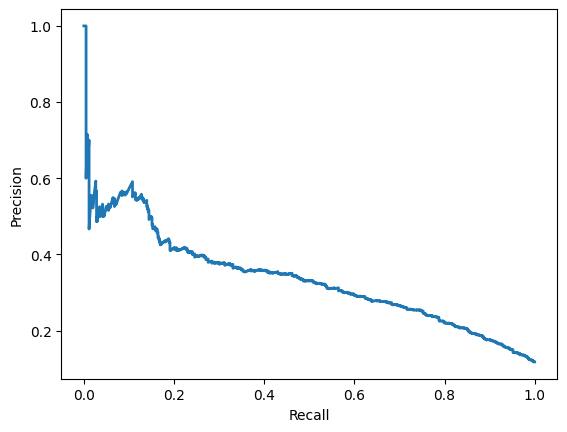

In [66]:
def plot_precision_vs_recall(precisions, recalls):
  plt.plot(recalls, precisions, linewidth=2)
  # Label the x-axis and y-axis
  plt.xlabel('Recall')
  plt.ylabel('Precision')

plot_precision_vs_recall(precisions, recalls)
plt.show()